In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist, mnist
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu'),
        layers.Dense(latent_dim // 2, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(latent_dim // 2, activation="relu"),
        layers.Dense(latent_dim, activation="relu"),
        layers.Dense(X_train.shape[1], activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def calculate_pairwise_distance(X_test, X_test_decoded):
    index_distance_map = []

    X_test_flattened = X_test.reshape(X_test.shape[0], -1)
    X_test_decoded_flattened = np.array(X_test_decoded).reshape(X_test_decoded.shape[0], -1)

    print('pairwise distances example 1')
    for i in range(len(X_test_decoded)):
        similarity_value = cosine_similarity([X_test_decoded_flattened[i]], [X_test_flattened[i]])[0][0]
        index_distance_map.append((i, similarity_value))
    return index_distance_map

def extract_top_100_features(model):
    """ Extract top 100 features per label class. """

    feature_indices = []

    # print('top 100 features for each label\n')
    for i in range(len(lr.coef_)):
        # print('label', i, end=' - ')
        # print(np.argsort(np.absolute(lr.coef_[i, :]))[-100:])
        top_100_features = np.argsort(np.absolute(lr.coef_[i, :]))[-100:]
        for feature_index in top_100_features:
            feature_indices.append(feature_index)
        return feature_indices

In [10]:
vectorizer = TfidfVectorizer(max_features=10000)

X_train = fetch_20newsgroups(subset='train')
X_test = fetch_20newsgroups(subset='test')
y_train = X_train.target
y_test = X_test.target

LABELS = set(y_train)

X_train = vectorizer.fit_transform(X_train.data).todense()
X_test = vectorizer.transform(X_test.data).todense()
X_val = X_train[-2000:]
y_val = y_train[-2000:]
print('X_train shape -', X_train.shape)
print('X_test shape -', X_test.shape)
print('X_val shape -', X_val.shape)
print('Labels -', LABELS)

X_train shape - (11314, 10000)
X_test shape - (7532, 10000)
X_val shape - (2000, 10000)
Labels - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [11]:
latent_dim = 10000

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=losses.MeanSquaredError()
)

autoencoder.fit(
X_train, X_train,
shuffle=True,
epochs=2,
batch_size=500,
callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1),
validation_data=(X_val, X_val)
)

Epoch 1/2
23/23 [==============================] - 85s 3s/step - loss: 0.1439 - val_loss: 1.0000e-04
Epoch 2/2
23/23 [==============================] - 79s 3s/step - loss: 1.0000e-04 - val_loss: 1.0000e-04


In [12]:
X_train_encoded = autoencoder.encoder(X_train)
X_test_encoded = autoencoder.encoder(X_test)
X_train_decoded = autoencoder.decoder(X_train_encoded)
X_test_decoded = autoencoder.decoder(X_test_encoded)

In [13]:
print(X_train_encoded.shape)
print(y_train.shape)

(11314, 5000)
(11314,)


In [16]:
lr = LogisticRegression().fit(X_train_encoded, y_train)
predictions = lr.predict(X_test_encoded)
accuracy = accuracy_score(y_test, predictions)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
print(accuracy)

0.7157461497610197


In [22]:
def plot_confusion_matrix(validations, predictions):
    """ Plot confusion matrix and compare real labels with predicted labels. """

    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(10, 5))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=set(y_test),
                yticklabels=set(y_test),
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

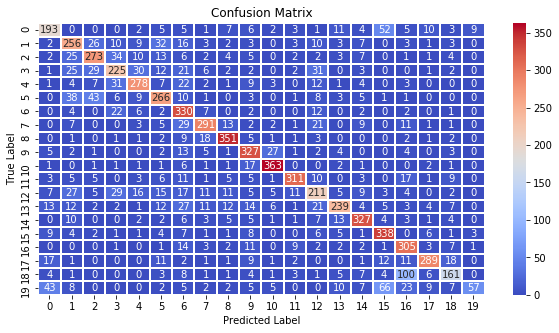

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_confusion_matrix(y_test, predictions)

In [24]:
related_words_indices = extract_top_100_features(lr)
new_features = np.array(X_train_encoded)[:, related_words_indices]
print('cosine similarity')
print(cosine_similarity(new_features))
print('\neuclidean distance')
print(euclidean_distances(new_features))

cosine similarity
[[1.         0.9999075  0.9999499  ... 0.9999259  0.9999426  0.99993646]
 [0.9999075  1.         0.99991643 ... 0.9999244  0.9999328  0.99990124]
 [0.9999499  0.99991643 0.99999976 ... 0.99994546 0.99995345 0.9999285 ]
 ...
 [0.9999259  0.9999244  0.99994546 ... 1.0000001  0.9999251  0.9999074 ]
 [0.9999426  0.9999328  0.99995345 ... 0.9999251  1.0000001  0.9999239 ]
 [0.99993646 0.99990124 0.9999285  ... 0.9999074  0.9999239  1.0000002 ]]

euclidean distance
[[0.         3.4242034  3.3505776  ... 3.5208488  0.8706775  3.2875364 ]
 [3.4242034  0.         6.7693734  ... 0.16248995 2.5654616  0.20237175]
 [3.3505776  6.7693734  0.         ... 6.866106   4.20782    6.6335397 ]
 ...
 [3.5208488  0.16248995 6.866106   ... 0.         2.6632833  0.2745738 ]
 [0.8706775  2.5654616  4.20782    ... 2.6632833  0.         2.430684  ]
 [3.2875364  0.20237175 6.6335397  ... 0.2745738  2.430684   0.        ]]
